In [1]:
%load_ext autoreload
%autoreload 2 

* 이미지를 VAE로 Embedding하여 얻은 vector의 similarity와 풍속데이터의 Similarity 비교
* 체크해야 할 것
    - 풍속기록이 있는 데이터만 필요하며, 일부는 Train 일부는 test 이를 구분해야 할 필요가 있음

In [2]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import yaml
import torch
from torchvision import transforms, datasets
from torch.utils.data import SubsetRandomSampler, DataLoader, TensorDataset

from src.hillshpaeDataModule import MySimCLRTrainDataTransform
from simCLR import *
from src import *

In [3]:
# Wind data load

with open('../../Share_Data/windspeed/_Main_dataset.pickle', 'rb') as f:
    windspeed_dataset = pickle.load(f)

# --- filter station for WAS journal!!
with open('../../Share_Data/windspeed/WAS_except_station_list_under_30_m.pickle', 'rb') as f:
    except_list = pickle.load(f)

new_windspeed_dataset = {}
for key in windspeed_dataset:
    if key not in except_list:
        new_windspeed_dataset[key] = windspeed_dataset[key]
        
windspeed_dataset = new_windspeed_dataset
# -------------------------------------- #
    
station_list = list(windspeed_dataset.keys())
windspeed_list = []
for item in windspeed_dataset.values():
    windspeed_list.append(item[3])
windspeed_list = np.array(windspeed_list)

In [4]:
# load config
config_path = 'configs/simclr_rgb.yaml'
checkpoint_path = '../../Share_Data/logs/SimCLR_CART/last.ckpt'

with open(config_path, 'rb') as f:
    config = yaml.safe_load(f)

#load vae model
untrained_model = simclr_model[config['model_params']['name']](**config['model_params'], num_samples=10)
model = simclr_model[config['model_params']['name']](**config['model_params'], num_samples=10)

#checkpoint load
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu')) # when using CPU
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [5]:
# load img data
IMG_PATH = '../../Share_Data/satellite/jpg_cart_d10/_jpg_cart_d10/{}.jpg'

img_list =[ ]
label_list = []
for station_code in station_list:
    img = Image.open(IMG_PATH.format(station_code)).resize([config['exp_parmas']['img_size']]*2)
    img_list.append(np.array(img))
    label_list.append(station_code)

img_list = (np.array(img_list)/255.)*2-1
tensor_img = torch.Tensor(img_list).permute(0,3,1,2)
tensor_dataset = TensorDataset(tensor_img)
dataloader = DataLoader(tensor_dataset)

In [6]:
model_latent = model.forward(tensor_img)
untrained_latent = untrained_model.forward(tensor_img)

model_projection = model.Projection(model_latent)
untrained_model_projection = untrained_model.Projection(untrained_latent)

print('size of latent : {}'.format(model_latent.size()))
print('size of projection : {}'.format(model_projection.size()))

size of latent : torch.Size([318, 512, 4, 4])
size of projection : torch.Size([318, 32])


# Analysis

In [7]:
#windspeed difference matrix

windspeed_diff_list = []
for i in windspeed_list:
    temp_list = []
    for j in windspeed_list:
        temp_list.append(abs(i-j))
    windspeed_diff_list.append(temp_list)
windspeed_diff_list = np.array(windspeed_diff_list)

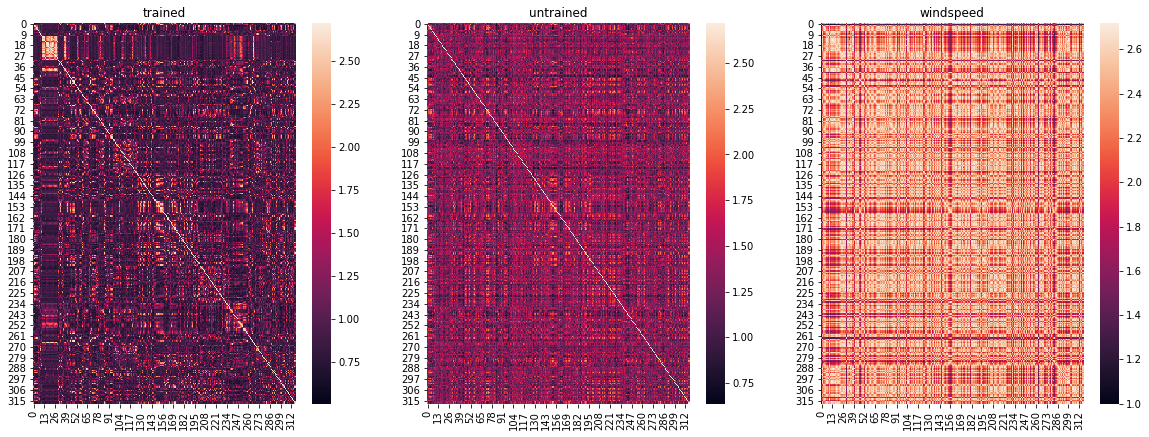

In [8]:
model_n = model_projection.norm(dim=1)[:,None]
model_n = torch.max(model_n, 1e-8*torch.ones_like(model_n))

un_model_n = untrained_model_projection.norm(dim=1)[:, None]
un_model_n = torch.max(un_model_n, 1e-8*torch.ones_like(un_model_n))

cov = torch.mm(model_projection/model_n, (model_projection/model_n).t().contiguous())
sim = torch.exp(cov)
untrained_cov = torch.mm(untrained_model_projection/un_model_n, (untrained_model_projection/un_model_n).t().contiguous())
untrained_sim = torch.exp(untrained_cov)

windspeed_diff = np.exp(-windspeed_diff_list/windspeed_diff_list.max()+1)

plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title('trained')
sns.heatmap(sim.detach().numpy())

plt.subplot(1,3,2)
plt.title('untrained')
sns.heatmap(untrained_sim.detach().numpy())

plt.subplot(1,3,3)
plt.title('windspeed')
sns.heatmap(windspeed_diff)
plt.show()

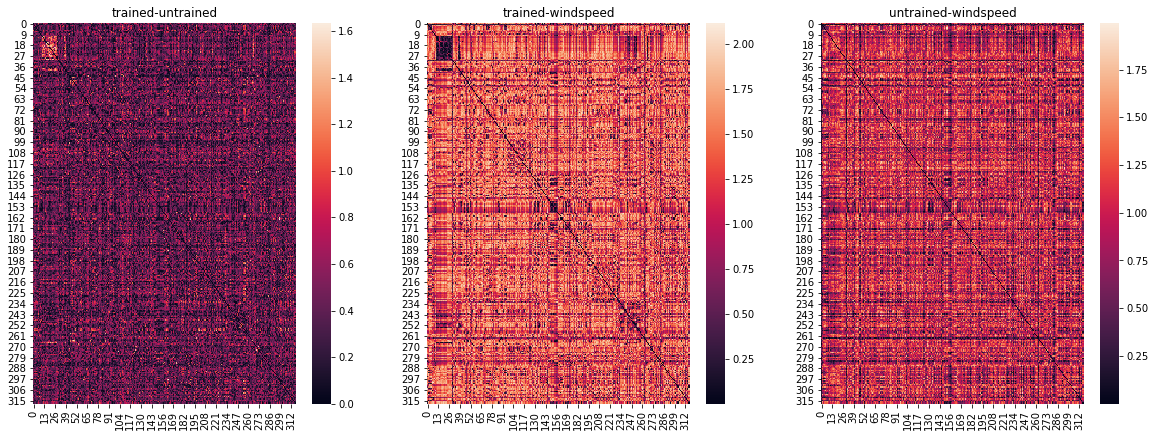

In [9]:
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.title('trained-untrained')
sns.heatmap(abs(sim.detach().numpy()-untrained_sim.detach().numpy()))

plt.subplot(1,3,2)
plt.title('trained-windspeed')
sns.heatmap(abs(sim.detach().numpy()-windspeed_diff))

plt.subplot(1,3,3)
plt.title('untrained-windspeed')
sns.heatmap(abs(untrained_sim.detach().numpy()-windspeed_diff))
plt.show()

## Analysis
---

[Experiment_1](#Experiment_1) - 위치기반 SVR

### Experiment_1 
* 위치기반하여 SVR
* k-hold-vaildation

In [10]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [11]:
# 거리로만
from IPython.display import clear_output

X = np.array(list(windspeed_dataset.values()))[:,:2]
windspeed_list = windspeed_list.reshape(-1)

clear_output()

In [12]:
kf = KFold(n_splits=10)
kf.get_n_splits(X)

10

In [13]:
result_list =[]
ans_list = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = windspeed_list[train_index], windspeed_list[test_index]
    
    regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
    regr.fit(X_train, Y_train)
    result_list.append(regr.predict(X_test))
    ans_list.append(Y_test)

In [14]:
error_list = list(map(lambda x : result_list[x]-ans_list[x], np.arange(kf.n_splits)))
total_error = list(map(lambda x : np.mean(np.abs(x)), error_list))

In [16]:
print('mean of error : {}'.format(np.mean(total_error)))

mean of error : 3.301263627858107


* 생각보다 잘 나오긴하는데
* 해당 Task는 굳이 NN을 사용하지 않아도 되지

In [17]:
# Hyperparameter

lr = 5e-4
epochs = 5000

kf = KFold(n_splits=10)
normal_x = StandardScaler().fit_transform(X)
log_y = np.log(windspeed_list)

In [18]:
nn_list = []
nn_ans_list = []

#loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

for train_index, test_index in kf.split(normal_x):
    X_train = torch.tensor(normal_x[train_index], dtype=torch.float32)
    X_test = torch.tensor(normal_x[test_index], dtype=torch.float32)
    Y_train = torch.tensor(windspeed_list[train_index].reshape(-1,1), dtype=torch.float32)
    Y_test = torch.tensor(windspeed_list[test_index].reshape(-1,1), dtype=torch.float32)
    
    #model reset
    model = torch.nn.Sequential(
            torch.nn.Linear(2, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,1))
    
    #Opt
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    schedulr = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
    
    for epoch in np.arange(epochs):
        y_pred = model(X_train)
        loss = loss_fn(y_pred, Y_train)
        opt.zero_grad()
        loss.backward()
        opt.step()
        schedulr.step(loss)
        if epoch % 100 == 0:
            print('step : {}, loss : {}'.format(epoch, loss.item()/len(y_pred)))
    
    print('---- training end ----')
    y_pred = model(X_test)
    loss = loss_fn(y_pred, Y_test)
    print('val loss : {}'.format(loss.item()))
    nn_list.append(y_pred.detach().numpy())
    nn_ans_list.append(Y_test.detach().numpy())
    clear_output()

In [19]:
result = list(map(lambda x : np.mean(np.abs(nn_ans_list[x] - nn_list[x])), np.arange(len(nn_ans_list))))
print(result)
print(np.mean(result))

[3.7572541, 3.344172, 2.216308, 3.5453944, 3.5181408, 2.822469, 2.7147949, 4.159629, 4.54025, 3.9485848]
3.4566998


In [149]:
result = list(map(lambda x : np.mean(np.abs(nn_ans_list[x] - nn_list[x])), np.arange(len(nn_ans_list))))
print(result)
print(np.mean(result))

[3.3729942, 3.5524478, 2.3723252, 2.6969068, 2.8846362, 3.3595045, 2.7867486, 4.1057005, 4.5895967, 4.1195188]
3.3840377


In [142]:
result = list(map(lambda x : np.mean(np.abs(nn_ans_list[x] - nn_list[x])), np.arange(len(nn_ans_list))))
print(result)
print(np.mean(result))

[3.47251, 3.5159757, 2.325559, 2.9339614, 3.0844433, 3.176426, 2.8345044, 4.050174, 4.5520773, 4.229054]
3.4174685


### NN 

* with latent vector

In [20]:
# SVR
# Hyperparameter

kf = KFold(n_splits=10)
latent = model_projection/model_n
normal_x = np.concatenate([StandardScaler().fit_transform(X), latent.detach().numpy()], axis=-1)
log_y = np.log(windspeed_list)

In [21]:
kf = KFold(n_splits=10)
kf.get_n_splits(normal_x)

10

In [22]:
result_list =[]
ans_list = []

for train_index, test_index in kf.split(X):
    X_train, X_test = normal_x[train_index], normal_x[test_index]
    Y_train, Y_test = windspeed_list[train_index], windspeed_list[test_index]
    
    #regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
    reg = SVR(C=1.0, epsilon=0.2)
    reg.fit(X_train, Y_train)
    result_list.append(reg.predict(X_test))
    ans_list.append(Y_test)

In [23]:
error_list = list(map(lambda x : result_list[x]-ans_list[x], np.arange(kf.n_splits)))
total_error = list(map(lambda x : np.mean(np.abs(x)), error_list))

In [24]:
print('mean of error : {}'.format(np.mean(total_error)))

mean of error : 3.3058831725989757


#### NN

In [167]:
# Hyperparameter

lr = 1e-4
epochs = 1500
kf = KFold(n_splits=10)
latent = model_projection/model_n
normal_x = np.concatenate([StandardScaler().fit_transform(X), latent.detach().numpy()], axis=-1)
log_y = np.log(windspeed_list)

In [168]:
train_loss = []
val_loss = []
total_result = []
nn_list = []
nn_ans_list = []

#loss function
loss_fn = torch.nn.MSELoss(reduction='mean')

for train_index, test_index in kf.split(normal_x):
    X_train = torch.tensor(normal_x[train_index], dtype=torch.float32)
    X_test = torch.tensor(normal_x[test_index], dtype=torch.float32)
#    Y_train = torch.tensor(log_y[train_index].reshape(-1,1), dtype=torch.float32)
#    Y_test = torch.tensor(log_y[test_index].reshape(-1,1), dtype=torch.float32)
    Y_train = torch.tensor(windspeed_list[train_index].reshape(-1,1), dtype=torch.float32)
    Y_test = torch.tensor(windspeed_list[test_index].reshape(-1,1), dtype=torch.float32)



    #model reset
    model = torch.nn.Sequential(
            torch.nn.Linear(34, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024,1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024,1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024,512),
            torch.nn.ReLU(),
            torch.nn.Linear(512,1))

    #Opt
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    schedulr = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
    
    temp_train_loss = []
    temp_test_loss = []
    
    for epoch in np.arange(epochs):
        y_pred = model(X_train)
        loss = loss_fn(y_pred, Y_train)
        temp_train_loss.append(float(loss.data))
        opt.zero_grad()
        loss.backward()
        opt.step()
        schedulr.step(loss)
        
        y_pred = model(X_test)
        loss = loss_fn(y_pred, Y_test)
        temp_test_loss.append(float(loss.data))
        
    train_loss.append(temp_train_loss)
    val_loss.append(temp_test_loss)
    
#    nn_list.append(np.exp(y_pred.detach().numpy()))
#    nn_ans_list.append(np.exp(Y_test.detach().numpy()))
    nn_list.append(y_pred.detach().numpy())
    nn_ans_list.append(Y_test.detach().numpy())
    total_result.append(np.mean(list(map(lambda x : np.mean(np.abs(nn_ans_list[x] - nn_list[x])), np.arange(len(nn_ans_list))))))

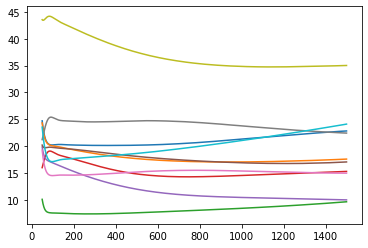

In [169]:
for i in np.arange(len(train_loss)):
#    plt.plot(np.arange(len(train_loss[i])), train_loss[i])
    plt.plot(np.arange(len(val_loss[i]))[50:], val_loss[i][50:])

In [170]:
print(total_result)
print(np.mean(total_result))

[3.62227, 3.345464, 3.141208, 3.1110606, 3.029972, 3.0478256, 3.0679574, 3.1456902, 3.3144443, 3.3860345]
3.2211926


In [173]:
torch.save(model.state_dict(), 'WAS_model')

In [174]:
test_model = torch.nn.Sequential(
            torch.nn.Linear(34, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024,1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024,1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024,512),
            torch.nn.ReLU(),
            torch.nn.Linear(512,1))

In [176]:
test_model.load_state_dict(torch.load('WAS_model'))

<All keys matched successfully>

In [114]:
print(total_result)
print(np.mean(total_result))

[3.312671, 3.347396, 3.160229, 3.1332514, 3.0017517, 3.1042824, 3.0894096, 3.1937537, 3.4063134, 3.4999619]
3.2249017


* 올....